- - -
- - -
hanna
- - -
- - -

# FINTECH BOOTCAMP - PROJECT 2
## Group 2 Notebook
---
By applying machine learning models, we examine (1) if selective technical indicators could predict the stock direction with statistically significant level (2) Which model is the best (3) Whether we could optimize the model (4) Which time frame the model could generate the best result. 

In [ ]:
# Initial import all libraries and dependencies
import yfinance as yf
import matplotlib.dates as mdates
import panel as pn
import datetime
import numpy as np
import pandas as pd
import hvplot.pandas
import holoviews as hv
from finta import TA
# from pandas_datareader import data
import matplotlib.pyplot as plt

# Ignore wanrings
import warnings
warnings.filterwarnings("ignore")


# Machine learning libraries
from sklearn.preprocessing import StandardScaler

In [ ]:
hv.extension('bokeh')

import plotly.express as px 
import plotly.io as pio

from holoviews.plotting.util import process_cmap

pio.renderers.default = 'notebook_connected'

## I. DATA FETCHING AND CLEANING

In [ ]:
# Define the instruments to download data of a stock/ETF .
tickers = ["AAPL", "TSLA", "MSFT", "SPY", "..."] # to be decided

# Fetch SPY Data from 1/1/2017 until 12/31/2021 and choosing a interval
start_date = datetime.date(2017,1,1)
end_date = datetime.date(2021,12,31)
interval = '1d'

In [ ]:
#Use pandas_reader.data.DataReader to load the desired data.
yf.Tickers(tickers[0])
panel_data = yf.download(tickers[0], start = start_date, end = end_date, interval = interval)

# Checkout the data type
type(panel_data)

In [ ]:
# Review data
panel_data.tail(5)

In [ ]:
# Data description and check if null
def data_description(df):
    print("Data Information")
    print(df.info())
    print("-"*50)

In [ ]:
data_description(panel_data) # if 0 null and OHLC is floating and Volumne is int, then data is clean to proceed to part II

In [ ]:
# IF data is not clean then dropping null or convert datatype
# def data_cleaning(df):
#     df.dropna()

In [ ]:
# Convert to ohlcv dataframe to be ready for finta
def ohlcv(df):
    del(df['Close'])
    df = df.rename(columns = {"Open": "open",'High' : 'high', 'Low' : "low", "Adj Close": "close", 'Volume': 'volume'},inplace = True)
    return df

In [ ]:
ohlcv(panel_data)
panel_data

## II. DATA PROCESSING AND PREPARATION

In [ ]:
# Timeframe for prediction
time_frame = [3,5,7]

# Identify stock direction
def stock_direction(df, days):# days is time frame
    direction = (df['close'].shift(-days) > df['close'])
    direction = direction.iloc[:-days]
    return direction.astype(int) #return y values

In [ ]:
stock_direction(panel_data,time_frame[0]) # y values

In [ ]:
# Using Finta calculate technical indicators
# Define key window to calculate for technical analysis 
window = [5,14,21,50]
def technical_indicators (df): # https://github.com/peerchemist/finta/blob/master/finta/finta.py
    x = pd.DataFrame()
    for n in range(len(window)) :  ### LOOPING DOES NOT SHOW(?)
        a = TA.BBANDS(df,window[n])
        a = a.add_prefix(f"{window[n]}_")
        b = TA.RSI(df,window[n])
        c = TA.PIVOT_FIB(df)
        c = c.add_prefix(f"{window[n]}_")
        d = TA.OBV(df)
        d.rename(f"{window[n]}_OBV", axis = 1, inplace = True)
        e = TA.SMA(df,window[n])
        f = TA.EMA(df,window[n])
        g = TA.ROC(df,window[n])
        g.rename(f"{window[n]}_ROC", axis = 1, inplace = True)
        k = TA.WILLIAMS(df,window[n])
        temp = pd.concat([a,b,c,d,e,f,g,k],axis = 1)
        x = pd.concat([x,temp],axis=1)
    return x

In [ ]:
technical_indicators(panel_data)

In [ ]:
def consol_data(df,days):
    consol_data = technical_indicators(df)
    consol_data["direction"] = stock_direction(df,days)
    consol_data.dropna(inplace = True)
    return consol_data

In [ ]:
data = consol_data(panel_data,time_frame[0])
data.info()

Encoding data

In [ ]:
# Create our features
X = data.copy()
X.drop("direction", axis = 1, inplace = True)
X.head()

In [ ]:
# Create our target
y = data["direction"].copy()
y.values.reshape(-1,1)

In [ ]:
# Checkout the balance of our target values
y.value_counts() # It's not that imbalance, ok to proceed further

Split the data into Training and Testing

In [ ]:
# Split the X and y into X_train, X_test, y_train, y_test
# Use 70% of the data for training and the remainder for testing
split = int(0.7 * len(X))
X_train = X[: split]
X_test = X[split:]
y_train = y[: split]
y_test = y[split:]

Scale the training and testing 

In [ ]:
# Create the StandardScaler instance
scaler = StandardScaler()
# Fit the Standard Scaler with the training data
# # Scale the training and testing data
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## III. CHOOSING MODELS AND TRAINING MODEL

### 1. Model 1. Random Forest Classifier

#### Import dependent libraries

In [ ]:
# library for 
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, roc_curve, auc

#### Modelling and Predicting

In [ ]:
rf_model = RandomForestClassifier(n_estimators = 250, random_state = 42)
rf_model = rf_model.fit(X_train_scaled,y_train)
y_train_pred = rf_model.predict(X_train_scaled)
y_pred = rf_model.predict(X_test_scaled)

##### Performance Report

In [ ]:
print(f"Accuracy_score is {accuracy_score(y_test,y_pred)}")
print("-"*50)
print("Confusion Matrix")
print(confusion_matrix(y_test, y_pred))
print("-"*50)
print("Classification Report")
print(classification_report(y_test, y_pred))

In [ ]:
# Plot ROC for Random Forest Classifier
fpr_train, tpr_train, thresholds_train = roc_curve(y_train, y_train_pred,pos_label=1)
auc_train = auc(fpr_train, tpr_train)
auc_train = round(auc_train, 4)
#fpr_test, tpr_test, thresholds_test = roc_curve(y_test, y_pred,pos_label=1)
fpr_test, tpr_test, thresholds_test = roc_curve(y_test, y_pred)
auc_test = auc(fpr_test, tpr_test)
auc_test = round(auc_test, 4)

# Create a DataFrame with the fpr and tpr results
roc_df_train = pd.DataFrame({"FPR": fpr_train, "TPR": tpr_train,})
roc_df_test = pd.DataFrame({"FPR": fpr_test, "TPR": tpr_test})

In [ ]:
# Plot roc train
plot_train = roc_df_train.plot(
    x="FPR",
    y="TPR",
    xlim=([-0.05, 1.05]),
    title=f"Train ROC Curve (AUC={auc_train})-RF",
)

In [ ]:
plot_test = roc_df_test.plot(
    x="FPR",
    y="TPR",
    color="red",
    style="--",
    xlim=([-0.05, 1.05]),
    title=f"Test ROC Curve (AUC={auc_test})-RF",
)

In [ ]:
# List the features sorted in descending order by feature importance
importances = rf_model.feature_importances_
df_importances = pd.DataFrame(sorted(zip(rf_model.feature_importances_, X.columns), reverse= True))
df_importances

In [ ]:
# Define the variable importance plot
def variable_importance(df):
    plot = df.hvplot.barh("1", stacked=True, height=1200)
    return plot

In [ ]:
# Plot the importance level 
variable_importance(df_importances)

#### IMPROVING AND TUNNING

Method 1. Hyper paramater tunning : Determine parameters for Random Forest

In [ ]:
# neccessary libraries
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, roc_curve, auc
from sklearn.model_selection import GridSearchCV

In [ ]:
# instantiate model, set parameter vars to determine most accurate random forest
random_forest_2_0 = RandomForestClassifier(
    verbose=True,
    random_state=42
)
param_rf = {
    "n_estimators":[5,10,50,100,250],
    "max_depth":[2,4,8,16,32,64,None]
}

In [ ]:
# GridSearchCV model selection for cross-validation
cross_validation = GridSearchCV(
    random_forest_2_0,
    param_rf,
    cv=5
)
cross_validation.fit(
    X_train,
    y_train.values.ravel()
)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_j

GridSearchCV(cv=5,
             estimator=RandomForestClassifier(random_state=42, verbose=True),
             param_grid={'max_depth': [2, 4, 8, 16, 32, 64, None],
                         'n_estimators': [5, 10, 50, 100, 250]})

In [ ]:
def display_cv(results_1):
    mean_score = results_1.cv_results_['mean_test_score']
    std_score = results_1.cv_results_['std_test_score']
    params = results_1.cv_results_['params']
    for mean,std,params in zip(mean_score,std_score,params):
        print(f'{round(mean,3)} + or -{round(std,3)} for the {params}')
    print("-"*50)
    print(f'Best parameters for Random Forest: {results_1.best_params_}')

display_cv(cross_validation)

0.537 + or -0.073 for the {'max_depth': 2, 'n_estimators': 5}
0.576 + or -0.041 for the {'max_depth': 2, 'n_estimators': 10}
0.574 + or -0.049 for the {'max_depth': 2, 'n_estimators': 50}
0.57 + or -0.059 for the {'max_depth': 2, 'n_estimators': 100}
0.576 + or -0.047 for the {'max_depth': 2, 'n_estimators': 250}
0.47 + or -0.133 for the {'max_depth': 4, 'n_estimators': 5}
0.467 + or -0.128 for the {'max_depth': 4, 'n_estimators': 10}
0.474 + or -0.138 for the {'max_depth': 4, 'n_estimators': 50}
0.471 + or -0.127 for the {'max_depth': 4, 'n_estimators': 100}
0.452 + or -0.151 for the {'max_depth': 4, 'n_estimators': 250}
0.435 + or -0.146 for the {'max_depth': 8, 'n_estimators': 5}
0.455 + or -0.13 for the {'max_depth': 8, 'n_estimators': 10}
0.444 + or -0.143 for the {'max_depth': 8, 'n_estimators': 50}
0.427 + or -0.148 for the {'max_depth': 8, 'n_estimators': 100}
0.419 + or -0.159 for the {'max_depth': 8, 'n_estimators': 250}
0.464 + or -0.142 for the {'max_depth': 16, 'n_estimato

Apply best parameters from GridSearchCV to rf_2
- - -

In [ ]:
# create model based on GridSearchCV best results, manual tuning
rf_2 = RandomForestClassifier(
    n_estimators = 10, 
    criterion = 'gini',
    max_depth = 2,
    min_samples_split = 50,
    max_features = 'log2',
    # bootstrap = True,
    # oob_score = bool,
    random_state = 42,
    verbose=True
)

# fit to training data
rf_2.fit(
    X_train,
    y_train
)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished


RandomForestClassifier(max_depth=2, max_features='log2', min_samples_split=50,
                       n_estimators=10, random_state=42, verbose=True)

In [ ]:
# X_test data set used for predictions
y_train_pred = rf_2.predict(X_train_scaled)
y_pred = rf_2.predict(X_test)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished


In [ ]:
# df of diffrence between actual v. predicted values
actual_predicted_df=pd.DataFrame({
        'Actual':y_test,
        'Predicted':y_pred
    }
)

actual_predicted_df

,Actual,Predicted
Date,,
2020-07-23,1.0,1.0
2020-07-24,1.0,1.0
2020-07-27,1.0,1.0
2020-07-28,1.0,1.0
2020-07-29,1.0,1.0
...,...,...
2021-12-20,1.0,1.0
2021-12-21,1.0,1.0
2021-12-22,1.0,1.0


In [ ]:
# df of diffrence between actual v. predicted values
actual_predicted_df=pd.DataFrame({
        'Actual':y_test,
        'Predicted':y_pred
    }
)

actual_predicted_df

,Actual,Predicted
Date,,
2020-07-23,1.0,1.0
2020-07-24,1.0,1.0
2020-07-27,1.0,1.0
2020-07-28,1.0,1.0
2020-07-29,1.0,1.0
...,...,...
2021-12-20,1.0,1.0
2021-12-21,1.0,1.0
2021-12-22,1.0,1.0


Performance Evaluation
- - -

In [ ]:
# feature importance as pandas series
print(f"Accuracy_score is {accuracy_score(y_test,y_pred)}")
print("-"*50)
print("Confusion Matrix")
print(confusion_matrix(y_test,y_pred))
print("-"*50)
print("Classification Report")
print(classification_report(y_test,y_pred))

Accuracy_score is 0.5844875346260388
--------------------------------------------------
Confusion Matrix
[[ 74  82]
 [ 68 137]]
--------------------------------------------------
Classification Report
              precision    recall  f1-score   support

         0.0       0.52      0.47      0.50       156
         1.0       0.63      0.67      0.65       205

    accuracy                           0.58       361
   macro avg       0.57      0.57      0.57       361
weighted avg       0.58      0.58      0.58       361



In [ ]:
# Plot ROC for rf_2 Classifier
fpr_train, tpr_train, thresholds_train = roc_curve(
    y_train,
    y_train_pred,
    pos_label=1
)
auc_train = auc(
    fpr_train,
    tpr_train
)
auc_train = round(
    auc_train,
    4
)

#fpr_test, tpr_test, thresholds_test = roc_curve(y_test, y_pred,pos_label=1)
fpr_test, tpr_test, thresholds_test = roc_curve(
    y_test,
    y_pred
)
auc_test = auc(
    fpr_test,
    tpr_test
)
auc_test = round(
    auc_test,
    4
)

# Create a DataFrame with the fpr and tpr results
roc_df_train = pd.DataFrame(
    {
        "FPR": fpr_train,
        "TPR": tpr_train
    }
)
roc_df_test = pd.DataFrame(
    {
        "FPR": fpr_test,
        "TPR": tpr_test
    }
)

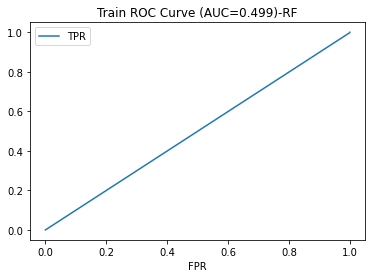

In [ ]:
# Plot roc train
plot_train = roc_df_train.plot(
    x="FPR",
    y="TPR",
    xlim=(
        [
            -0.05,
            1.05
        ]
    ),
    title=f"Train ROC Curve (AUC={auc_train})-RF",
)

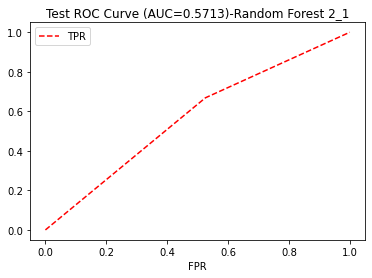

In [ ]:
plot_test = roc_df_test.plot(
    x="FPR",
    y="TPR",
    color="red",
    style="--",
    xlim=(
        [
            -0.05,
            1.05
        ]
    ),
    title=f"Test ROC Curve (AUC={auc_test})-Random Forest 2_1",
)

In [ ]:
# List the features sorted in descending order by feature importance
importances = rf_2.feature_importances_
df_importances = pd.DataFrame(
    sorted(
        zip(
            rf_2.feature_importances_,
            X.columns
        ),
        reverse= True
    )
)

df_importances

,0,1
0,0.120838,14_s4
1,0.100187,21 period SMA
2,0.094939,14 period RSI
3,0.068223,5_BB_LOWER
4,0.057646,14_ROC
...,...,...
67,0.000000,14_BB_UPPER
68,0.000000,14_BB_MIDDLE
69,0.000000,14_BB_LOWER
70,0.000000,14 period SMA


In [ ]:
# Define the variable importance plot
def variable_importance(df):
    plot = df.hvplot.barh(
        "1",
        stacked=True,
        height=800
    )
    return plot

In [ ]:
# Plot the importance level 
variable_importance(df_importances)

:Bars   [1]   (0)

Method 2. Improve the X variables quality by deleting all the insignificant features and adding more leading technical indicators

In [ ]:
# Define key window to calculate for technical analysis 
window = [5,14,21,50]
def technical_indicators (df): # https://github.com/peerchemist/finta/blob/master/finta/finta.py
    x = pd.DataFrame()
    for n in range(len(window)) :  ### LOOPING DOES NOT SHOW(?)
        #a = TA.BBANDS(df,window[n])
        b = TA.RSI(df,window[n])
        #c = TA.PIVOT_FIB(df) 
        #d = TA.OBV(df)
        #e = TA.SMA(df,window[n])
        #f = TA.EMA(df,window[n])
        g = TA.ROC(df,window[n])
        g.rename(f"{window[n]}_ROC", axis = 1, inplace = True)
        k = TA.WILLIAMS(df,window[n])
        l = TA.CCI(df,window[n]) # add to test
        m = TA.DMI(df,window[n])
        m = m.add_prefix(f"{window[n]}_") # DELETE n in define name
        #o = TA.PSAR(df) #m
        #o = o.add_prefix(f"{window[n]}_") # DELETE n in define name
        temp = pd.concat([b,g,k,l,m],axis = 1) #a, c,d,e,f,m
        x = pd.concat([x,temp],axis=1)
    return x

In [ ]:
def consol_data(df,days):
    consol_data = technical_indicators(df)
    consol_data["direction"] = stock_direction(df,days)
    consol_data.dropna(inplace = True)
    return consol_data

In [ ]:
data = consol_data(panel_data,time_frame[1])
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1203 entries, 2017-03-16 to 2021-12-22
Data columns (total 25 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   5 period RSI    1203 non-null   float64
 1   5_ROC           1203 non-null   float64
 2   5 Williams %R   1203 non-null   float64
 3   5 period CCI    1203 non-null   float64
 4   5_DI+           1203 non-null   float64
 5   5_DI-           1203 non-null   float64
 6   14 period RSI   1203 non-null   float64
 7   14_ROC          1203 non-null   float64
 8   14 Williams %R  1203 non-null   float64
 9   14 period CCI   1203 non-null   float64
 10  14_DI+          1203 non-null   float64
 11  14_DI-          1203 non-null   float64
 12  21 period RSI   1203 non-null   float64
 13  21_ROC          1203 non-null   float64
 14  21 Williams %R  1203 non-null   float64
 15  21 period CCI   1203 non-null   float64
 16  21_DI+          1203 non-null   float64
 17  21_DI-         

Encoding data

In [ ]:
# Create our features
X = data.copy()
X.drop("direction", axis = 1, inplace = True)
X.head()

,5 period RSI,5_ROC,5 Williams %R,5 period CCI,5_DI+,5_DI-,14 period RSI,14_ROC,14 Williams %R,14 period CCI,...,21 Williams %R,21 period CCI,21_DI+,21_DI-,50 period RSI,50_ROC,50 Williams %R,50 period CCI,50_DI+,50_DI-
Date,,,,,,,,,,,,,,,,,,,,,
2017-03-16,79.088442,1.449372,-343.955480,115.856760,4.766093,1.598035,79.389130,2.948923,-172.703539,158.073373,...,-127.908524,117.153033,6.820949,1.449256,83.593612,21.653013,-32.394760,94.612117,8.246663,0.000000
2017-03-17,59.715344,0.610907,-402.138314,50.458649,3.812853,2.151622,73.064849,2.234767,-204.792029,131.870950,...,-143.155652,94.782565,6.409871,1.628924,81.004795,21.183380,-35.093329,88.800759,5.442057,1.501174
2017-03-20,75.481546,1.623577,-298.463224,106.435711,4.196011,1.721290,77.176811,3.262978,-178.407599,179.458677,...,-124.049067,123.222055,6.381952,1.531979,82.186960,21.836299,-31.718470,92.685003,5.571174,1.114432
2017-03-21,49.041174,0.611532,-285.641374,48.773106,6.267934,1.377027,65.338431,0.035770,-187.281600,116.281075,...,-143.200610,108.175085,6.908920,1.441876,76.811177,19.113136,-43.317344,88.141154,7.622715,0.882450
2017-03-22,64.290695,0.683476,-302.178970,52.546955,5.014333,1.101619,70.147956,1.770269,-161.337678,102.801244,...,-123.363181,111.505255,6.507073,1.358012,78.228409,19.365597,-37.726373,86.814504,6.287243,0.727848


In [ ]:
# Create our target
y = data["direction"].copy()
y.values.reshape(-1,1)[0:3]

array([[1.],
       [1.],
       [0.]])

In [ ]:
# Split the X and y into X_train, X_test, y_train, y_test
# Use 70% of the data for training and the remainder for testing
split = int(0.7 * len(X))
X_train = X[: split]
X_test = X[split:]
y_train = y[: split]
y_test = y[split:]

In [ ]:
# Create the StandardScaler instance
scaler = StandardScaler()
# Fit the Standard Scaler with the training data
# # Scale the training and testing data
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
rf_model = RandomForestClassifier(n_estimators = 500, random_state = 42)
rf_model = rf_model.fit(X_train_scaled,y_train)
y_train_pred = rf_model.predict(X_train_scaled)
y_pred = rf_model.predict(X_test_scaled)

Performance Evaluation

In [ ]:
print(f"Accuracy_score is {accuracy_score(y_test,y_pred)}")
print("-"*50)
print("Confusion Matrix")
print(confusion_matrix(y_test, y_pred))
print("-"*50)
print("Classification Report")
print(classification_report(y_test, y_pred))

Accuracy_score is 0.5512465373961218
--------------------------------------------------
Confusion Matrix
[[ 68  78]
 [ 84 131]]
--------------------------------------------------
Classification Report
              precision    recall  f1-score   support

         0.0       0.45      0.47      0.46       146
         1.0       0.63      0.61      0.62       215

    accuracy                           0.55       361
   macro avg       0.54      0.54      0.54       361
weighted avg       0.55      0.55      0.55       361



In [ ]:
# Plot ROC for Random Forest Classifier
fpr_train, tpr_train, thresholds_train = roc_curve(y_train, y_train_pred,pos_label=1)
auc_train = auc(fpr_train, tpr_train)
auc_train = round(auc_train, 4)
#fpr_test, tpr_test, thresholds_test = roc_curve(y_test, y_pred,pos_label=1)
fpr_test, tpr_test, thresholds_test = roc_curve(y_test, y_pred)
auc_test = auc(fpr_test, tpr_test)
auc_test = round(auc_test, 4)

# Create a DataFrame with the fpr and tpr results
roc_df_train = pd.DataFrame({"FPR": fpr_train, "TPR": tpr_train,})
roc_df_test = pd.DataFrame({"FPR": fpr_test, "TPR": tpr_test})

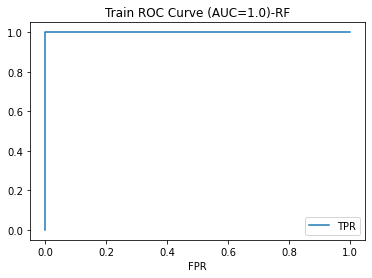

In [ ]:
# Plot roc train
plot_train = roc_df_train.plot(
    x="FPR",
    y="TPR",
    xlim=([-0.05, 1.05]),
    title=f"Train ROC Curve (AUC={auc_train})-RF",
)

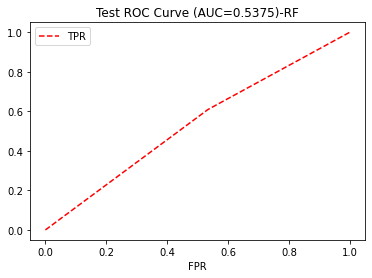

In [ ]:
plot_test = roc_df_test.plot(
    x="FPR",
    y="TPR",
    color="red",
    style="--",
    xlim=([-0.05, 1.05]),
    title=f"Test ROC Curve (AUC={auc_test})-RF",
)

In [ ]:
# List the features sorted in descending order by feature importance
importances = rf_model.feature_importances_
df_importances = pd.DataFrame(sorted(zip(rf_model.feature_importances_, X.columns), reverse= True))
df_importances

,0,1
0,0.057090,50_DI+
1,0.051288,14_ROC
2,0.049383,5_DI-
3,0.049094,21_DI+
4,0.046421,14_DI+
5,0.045458,50 Williams %R
6,0.044171,21 Williams %R
7,0.043918,14_DI-
8,0.043504,21_DI-
9,0.043169,21_ROC


In [ ]:
# Define the variable importance plot
def variable_importance(df):
    plot = df.hvplot.barh("1", stacked=True, height=800)
    return plot

In [ ]:
# Plot the importance level 
variable_importance(df_importances)

:Bars   [1]   (0)

#### Comments on Random Forest Classifer on this Project

1. The result after hyper Paramater Tuning is great, however the training model is not good
2. Adding more data is good but in pratice it shouldnt be used

- - -
- - -
nedal
- - -
- - -

# FINTECH BOOTCAMP - PROJECT 2
## Group 2 Notebook
---
By applying machine learning models, we examine (1) if selective technical indicators could predict the stock direction with statistically significant level (2) Which model is the best (3) Whether we could optimize the model (4) Which time frame the model could generate the best result. 

In [ ]:
# Initial import all libraries and dependencies
import yfinance as yf
import matplotlib.dates as mdates
import panel as pn
import datetime
import numpy as np
import pandas as pd
import hvplot.pandas
from finta import TA
# from pandas_datareader import data
import matplotlib.pyplot as plt

# Ignore wanrings
import warnings
warnings.filterwarnings("ignore")


# Machine learning libraries
from sklearn.preprocessing import StandardScaler

### I. DATA FETCHING AND CLEANING

In [ ]:
# Define the instruments to download data of a stock/ETF .
tickers = ["AAPL", "TSLA", "MSFT", "SPY", "..."] # to be decided

# Fetch SPY Data from 1/1/2017 until 12/31/2021 and choosing a interval
start_date = datetime.date(2017,1,1)
end_date = datetime.date(2021,12,31)
interval = '1d'

In [ ]:
#Use pandas_reader.data.DataReader to load the desired data.
yf.Tickers(tickers[0])
panel_data = yf.download(tickers[0], start = start_date, end = end_date, interval = interval)

# Checkout the data type
type(panel_data)

[*********************100%***********************]  1 of 1 completed


pandas.core.frame.DataFrame

In [ ]:
# Review data
panel_data.head(5)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2017-01-03,28.950001,29.082500,28.690001,29.037500,27.297688,115127600
2017-01-04,28.962500,29.127501,28.937500,29.004999,27.267136,84472400
2017-01-05,28.980000,29.215000,28.952499,29.152500,27.405806,88774400
2017-01-06,29.195000,29.540001,29.117500,29.477501,27.711327,127007600
2017-01-09,29.487499,29.857500,29.485001,29.747499,27.965151,134247600


In [ ]:
# Data description and check if null
def data_description(df):
    print("Data Information")
    print(df.info())
    print("-"*50)

In [ ]:
data_description(panel_data) # if 0 null and OHLC is floating and Volumne is int, then data is clean to proceed to part II

Data Information
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1258 entries, 2017-01-03 to 2021-12-30
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       1258 non-null   float64
 1   High       1258 non-null   float64
 2   Low        1258 non-null   float64
 3   Close      1258 non-null   float64
 4   Adj Close  1258 non-null   float64
 5   Volume     1258 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 68.8 KB
None
--------------------------------------------------


In [ ]:
# IF data is note clean then dropping null or convert datatype
# def data_cleaning(df):
#     df.dropna()

In [ ]:
# Convert to ohlcv dataframe to be ready for finta
def ohlcv(df):
    del(df['Close'])
    df = df.rename(columns = {"Open": "open",'High' : 'high', 'Low' : "low", "Adj Close": "close", 'Volume': 'volume'},inplace = True)
    return df

In [ ]:
ohlcv(panel_data)
panel_data

,open,high,low,close,volume
Date,,,,,
2017-01-03,28.950001,29.082500,28.690001,27.297688,115127600
2017-01-04,28.962500,29.127501,28.937500,27.267136,84472400
2017-01-05,28.980000,29.215000,28.952499,27.405806,88774400
2017-01-06,29.195000,29.540001,29.117500,27.711327,127007600
2017-01-09,29.487499,29.857500,29.485001,27.965151,134247600
...,...,...,...,...,...
2021-12-23,175.850006,176.850006,175.270004,176.055695,68356600
2021-12-27,177.089996,180.419998,177.070007,180.100540,74919600
2021-12-28,180.160004,181.330002,178.529999,179.061859,79144300


### II. DATA PROCESSING AND PREPARATION

In [ ]:
# Timeframe for prediction
time_frame = [3,5,7]

# Identify stock direction
def stock_direction(df, days):# days is time frame
    direction = (df['close'].shift(-days) > df['close'])
    direction = direction.iloc[:-days]
    return direction.astype(int) #return y values

In [ ]:
stock_direction(panel_data,time_frame[0]) # y values

Date
2017-01-03    1
2017-01-04    1
2017-01-05    1
2017-01-06    1
2017-01-09    1
             ..
2021-12-20    1
2021-12-21    1
2021-12-22    1
2021-12-23    1
2021-12-27    0
Name: close, Length: 1255, dtype: int64

In [ ]:
# Using Finta calculate technical indicators
# Define key window to calculate for technical analysis 
window = [5,14,21,50]
def technical_indicators (df): # https://github.com/peerchemist/finta/blob/master/finta/finta.py
    x = pd.DataFrame()
    for n in range(len(window)) :  ### LOOPING DOES NOT SHOW(?)
        a = TA.BBANDS(df,window[n])
        b = TA.RSI(df,window[n])
        c = TA.PIVOT_FIB(df)
        d = TA.OBV(df)
        e = TA.SMA(df,window[n])
        f = TA.EMA(df,window[n])
        g = TA.ROC(df,window[n])
        k = TA.WILLIAMS(df,window[n])
        temp = pd.concat([a,b,c,d,e,f,g,k],axis = 1)
        x = pd.concat([x,temp],axis=1)
    return x

In [ ]:
technical_indicators(panel_data)

,BB_UPPER,BB_MIDDLE,BB_LOWER,5 period RSI,pivot,s1,s2,s3,s4,r1,...,s4,r1,r2,r3,r4,OBV,50 period SMA,50 period EMA,ROC,50 Williams %R
Date,,,,,,,,,,,,,,,,,,,,,
2017-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,27.297688,NaN,NaN
2017-01-04,NaN,NaN,NaN,0.000000,28.356730,28.206795,28.114165,27.964230,27.814295,28.506664,...,27.814295,28.506664,28.599294,28.749229,28.899164,-8.447240e+07,NaN,27.282106,NaN,NaN
2017-01-05,NaN,NaN,NaN,85.015447,28.444045,28.371465,28.326625,28.254045,28.181465,28.516626,...,28.181465,28.516626,28.561466,28.634046,28.706626,4.302000e+06,NaN,27.324999,NaN,NaN
2017-01-06,NaN,NaN,NaN,95.515421,28.524435,28.424160,28.362210,28.261934,28.161659,28.624710,...,28.161659,28.624710,28.686661,28.786936,28.887211,1.313096e+08,NaN,27.427452,NaN,NaN
2017-01-09,28.130025,27.529421,26.928817,97.404292,28.789609,28.628214,28.528504,28.367109,28.205713,28.951005,...,28.205713,28.951005,29.050715,29.212110,29.373505,2.655572e+08,NaN,27.543763,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-23,178.555870,172.939664,167.323457,63.064880,174.475499,173.058277,172.182715,170.765493,169.348270,175.892722,...,169.348270,175.892722,176.768284,178.185506,179.602729,6.060665e+09,158.594117,161.579138,25.283713,-14.953985
2021-12-27,182.643087,174.775323,166.907560,73.632224,176.058568,175.455008,175.082127,174.478566,173.875006,176.662129,...,173.875006,176.662129,177.035009,177.638570,178.242131,6.135585e+09,159.328771,162.305468,25.621307,-5.207762
2021-12-28,182.567197,176.680896,170.794595,67.438857,179.196849,177.917152,177.126554,175.846858,174.567161,180.476545,...,174.567161,180.476545,181.267143,182.546839,183.826536,6.056440e+09,160.021110,162.962581,23.965524,-7.873096


In [ ]:
def consol_data(df,days):
    consol_data = technical_indicators(df)
    consol_data["direction"] = stock_direction(df,days)
    consol_data.dropna(inplace = True)
    return consol_data

In [ ]:
data = consol_data(panel_data,time_frame[0])
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1203 entries, 2017-03-16 to 2021-12-27
Data columns (total 73 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   BB_UPPER        1203 non-null   float64
 1   BB_MIDDLE       1203 non-null   float64
 2   BB_LOWER        1203 non-null   float64
 3   5 period RSI    1203 non-null   float64
 4   pivot           1203 non-null   float64
 5   s1              1203 non-null   float64
 6   s2              1203 non-null   float64
 7   s3              1203 non-null   float64
 8   s4              1203 non-null   float64
 9   r1              1203 non-null   float64
 10  r2              1203 non-null   float64
 11  r3              1203 non-null   float64
 12  r4              1203 non-null   float64
 13  OBV             1203 non-null   float64
 14  5 period SMA    1203 non-null   float64
 15  5 period EMA    1203 non-null   float64
 16  ROC             1203 non-null   float64
 17  5 Williams %R  

In [ ]:
data.columns

Index(['BB_UPPER', 'BB_MIDDLE', 'BB_LOWER', '5 period RSI', 'pivot', 's1',
       's2', 's3', 's4', 'r1', 'r2', 'r3', 'r4', 'OBV', '5 period SMA',
       '5 period EMA', 'ROC', '5 Williams %R', 'BB_UPPER', 'BB_MIDDLE',
       'BB_LOWER', '14 period RSI', 'pivot', 's1', 's2', 's3', 's4', 'r1',
       'r2', 'r3', 'r4', 'OBV', '14 period SMA', '14 period EMA', 'ROC',
       '14 Williams %R', 'BB_UPPER', 'BB_MIDDLE', 'BB_LOWER', '21 period RSI',
       'pivot', 's1', 's2', 's3', 's4', 'r1', 'r2', 'r3', 'r4', 'OBV',
       '21 period SMA', '21 period EMA', 'ROC', '21 Williams %R', 'BB_UPPER',
       'BB_MIDDLE', 'BB_LOWER', '50 period RSI', 'pivot', 's1', 's2', 's3',
       's4', 'r1', 'r2', 'r3', 'r4', 'OBV', '50 period SMA', '50 period EMA',
       'ROC', '50 Williams %R', 'direction'],
      dtype='object')

### III. CHOOSING MODELS AND TRAINING MODEL (INDIVIDUAL WORK)

#### 1. Model 1......

## LSTM

In [ ]:
# Set the random seed for reproducibility
# Note: This is used for model prototyping, but it is good practice to comment this out and run multiple experiments to evaluate your model.
from numpy.random import seed

seed(1)
from tensorflow import random

random.set_seed(2)

In [ ]:
def window_data(df, window, feature_col_number, target_col_number):
    """
    This function accepts the column number for the features (X) and the target (y).
    It chunks the data up with a rolling window of Xt - window to predict Xt.
    It returns two numpy arrays of X and y.
    """
    X = []
    y = []
    for i in range(len(df) - window):
        features = df.iloc[i:(i + window), feature_col_number]
        target = df.iloc[(i + window), target_col_number]
        X.append(features)
        y.append(target)
    return np.array(X), np.array(y).reshape(-1, 1)

In [ ]:
# Creating the features (X) and target (y) data using the window_data() function.
window_size = 30

feature_column =[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27]
target_column =[72]
X, y = window_data(data, window_size, feature_column, target_column)
# print (f"X sample values:\n{X[:5]} \n")
print (f"y sample values:\n{X[:5]}")

y sample values:
[[[32.9738472  32.59140025 79.08799095 ... 33.93639374 33.77213362
   34.53065416]
  [33.01397324 32.65927809 59.71492097 ... 34.31948598 34.24690505
   34.58206936]
  [33.1206604  32.68968995 75.48079089 ... 34.14441427 34.03840921
   34.52791948]
  ...
  [33.68573227 32.9949537  75.8168185  ... 35.03658676 34.96305135
   35.30262324]
  [33.82735748 33.38121391 60.71748701 ... 35.17828369 35.07991881
   35.53414827]
  [33.89108658 33.50494666 61.94330277 ... 34.99807485 34.88156473
   35.41958527]]

 [[33.01397324 32.65927809 59.71492097 ... 34.31948598 34.24690505
   34.58206936]
  [33.1206604  32.68968995 75.48079089 ... 34.14441427 34.03840921
   34.52791948]
  [33.16078644 32.8572072  49.04151589 ... 34.29006704 34.16878163
   34.72885351]
  ...
  [33.82735748 33.38121391 60.71748701 ... 35.17828369 35.07991881
   35.53414827]
  [33.89108658 33.50494666 61.94330277 ... 34.99807485 34.88156473
   35.41958527]
  [33.95623398 33.77667587 59.01389395 ... 35.05672582 3

In [ ]:
# Use 70% of the data for training and the remaineder for testing
split=int(0.7 * len(X))
X_train=X[: split]
X_test=X[split :]
y_train=y[: split]
y_test=y[split :]


In [ ]:
X_train

array([[[ 32.9738472 ,  32.59140025,  79.08799095, ...,  33.93639374,
          33.77213362,  34.53065416],
        [ 33.01397324,  32.65927809,  59.71492097, ...,  34.31948598,
          34.24690505,  34.58206936],
        [ 33.1206604 ,  32.68968995,  75.48079089, ...,  34.14441427,
          34.03840921,  34.52791948],
        ...,
        [ 33.68573227,  32.9949537 ,  75.8168185 , ...,  35.03658676,
          34.96305135,  35.30262324],
        [ 33.82735748,  33.38121391,  60.71748701, ...,  35.17828369,
          35.07991881,  35.53414827],
        [ 33.89108658,  33.50494666,  61.94330277, ...,  34.99807485,
          34.88156473,  35.41958527]],

       [[ 33.01397324,  32.65927809,  59.71492097, ...,  34.31948598,
          34.24690505,  34.58206936],
        [ 33.1206604 ,  32.68968995,  75.48079089, ...,  34.14441427,
          34.03840921,  34.52791948],
        [ 33.16078644,  32.8572072 ,  49.04151589, ...,  34.29006704,
          34.16878163,  34.72885351],
        ...,


In [ ]:
# reshape the X and y to be in 2d array as the  MinMaxScaler only accept 2d arrays 

In [ ]:
nsamples, nx, ny = X_train.shape
X_train = X_train.reshape((nsamples,nx*ny))

In [ ]:
nsamples, nx, ny = X_test.shape
X_test=X_test.reshape((nsamples,nx*ny))
X_test

array([[ 87.23948822,  85.50045234,  77.33763022, ..., 105.34892782,
        103.91833968, 110.52451107],
       [ 87.95412445,  84.49442966,  83.58327038, ..., 106.81377411,
        105.89601759, 110.13403459],
       [ 88.37301331,  85.0212882 ,  64.74422325, ..., 107.88983663,
        107.31874558, 109.95593043],
       ...,
       [150.71582642, 149.99168125,  57.80508912, ..., 166.07133993,
        164.87950179, 170.38317318],
       [150.04683228, 147.38960057,  32.17307801, ..., 167.61662292,
        166.05806223, 173.25518546],
       [149.47356262, 146.19339093,  31.86744855, ..., 170.76549276,
        169.34827019, 175.89272204]])

In [ ]:
# Use the MinMaxScaler to scale data between 0 and 1.
from sklearn.preprocessing import MinMaxScaler

# Create a MinMaxScaler object
scaler = MinMaxScaler()

# Fit the MinMaxScaler object with the training feature data X_train
scaler.fit(X_train)

# Scale the features training and testing sets
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# Fit the MinMaxScaler object with the training target data y_train
scaler.fit(y_train)

# Scale the target training and testing sets
y_train = scaler.transform(y_train)
y_test = scaler.transform(y_test)

### Reducing Dimensions Using PCA

In [ ]:
# Use PCA to reduce dimensions to 3 principal components
from sklearn.decomposition import PCA
pca = PCA(n_components=3)
X_train= pca.fit_transform(X_train)
X_test=pca.transform(X_test)
print(X_train)

[[-7.08727791 -0.57985257 -0.93663438]
 [-7.08598618 -0.53899122 -0.8605072 ]
 [-7.07133052 -0.53379373 -0.77634921]
 ...
 [17.86049669  0.10968198  0.21498591]
 [17.99144716  0.16809467  0.22711608]
 [18.18357607  0.15318316  0.31972979]]


In [ ]:
pca.explained_variance_ratio_

array([0.87088546, 0.04410556, 0.0230181 ])

In [ ]:
# Reshape the features for the model
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))
print (f"X_train sample values:\n{X_train[:5]} \n")
print (f"X_test sample values:\n{X_test[:5]}")

X_train sample values:
[[[-7.08727791]
  [-0.57985257]
  [-0.93663438]]

 [[-7.08598618]
  [-0.53899122]
  [-0.8605072 ]]

 [[-7.07133052]
  [-0.53379373]
  [-0.77634921]]

 [[-7.05461527]
  [-0.53805171]
  [-0.64562814]]

 [[-7.03143802]
  [-0.55431532]
  [-0.5793746 ]]] 

X_test sample values:
[[[ 1.84514421e+01]
  [ 8.64048753e-02]
  [ 4.54066174e-01]]

 [[ 1.87389132e+01]
  [ 1.49429714e-02]
  [ 6.30390839e-01]]

 [[ 1.90238936e+01]
  [-9.60550786e-02]
  [ 8.37059133e-01]]

 [[ 1.93001553e+01]
  [-2.24987284e-01]
  [ 9.53880619e-01]]

 [[ 1.95892700e+01]
  [-3.39152322e-01]
  [ 1.07781941e+00]]]


### Build and Train the LSTM RNN

In this section, we will design a custom LSTM RNN in Keras and fit (train) it using the training data we defined.

You we need to:

1. Define the model architecture in Keras.

2. Compile the model.

3. Fit the model with the training data.

In [ ]:
# Importing required Keras modules
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

In [ ]:
X_train.shape[1]

3

In [ ]:
# Define the LSTM RNN model.
model = Sequential()

# Initial model setup
number_units = 30
dropout_fraction = 0.5

# Layer 1
model.add(LSTM(
    units=number_units,
    return_sequences=True,
    input_shape=(X_train.shape[1], 1)))
    
model.add(Dropout(dropout_fraction))

# Layer 2
model.add(LSTM(units=number_units, return_sequences=True))
model.add(Dropout(dropout_fraction))

# Layer 3
model.add(LSTM(units=number_units))
model.add(Dropout(dropout_fraction))

# Output layer
model.add(Dense(1, activation = "sigmoid"))

#### Compile the LSTM RNN Model



In [ ]:
# Compile the model
model.compile(optimizer="adam", metrics="accuracy", loss = "binary_crossentropy")

In [ ]:
# Show the model summary
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 3, 30)             3840      
                                                                 
 dropout_3 (Dropout)         (None, 3, 30)             0         
                                                                 
 lstm_4 (LSTM)               (None, 3, 30)             7320      
                                                                 
 dropout_4 (Dropout)         (None, 3, 30)             0         
                                                                 
 lstm_5 (LSTM)               (None, 30)                7320      
                                                                 
 dropout_5 (Dropout)         (None, 30)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='accuracy',
                               patience=10,
                               mode='max',
                               restore_best_weights=True)

In [ ]:
# Train the model
model.fit(X_train ,y_train, epochs=100, shuffle=False, batch_size=16, verbose=1,callbacks=[early_stopping])

Epoch 1/100
52/52 [==============================] - 3s 5ms/step - loss: 0.6896 - accuracy: 0.5761
Epoch 2/100
52/52 [==============================] - 0s 4ms/step - loss: 0.6756 - accuracy: 0.6066
Epoch 3/100
52/52 [==============================] - 0s 4ms/step - loss: 0.6716 - accuracy: 0.6066
Epoch 4/100
52/52 [==============================] - 0s 4ms/step - loss: 0.6723 - accuracy: 0.6066
Epoch 5/100
52/52 [==============================] - 0s 4ms/step - loss: 0.6707 - accuracy: 0.6066
Epoch 6/100
52/52 [==============================] - 0s 4ms/step - loss: 0.6712 - accuracy: 0.6066
Epoch 7/100
52/52 [==============================] - 0s 4ms/step - loss: 0.6702 - accuracy: 0.6066
Epoch 8/100
52/52 [==============================] - 0s 4ms/step - loss: 0.6708 - accuracy: 0.6066
Epoch 9/100
52/52 [==============================] - 0s 4ms/step - loss: 0.6726 - accuracy: 0.6066
Epoch 10/100
52/52 [==============================] - 0s 4ms/step - loss: 0.6675 - accuracy: 0.6066
Epoch 11/

## Model Performance


In [ ]:
# Evaluate the model
model.evaluate(X_test, y_test, verbose=0)

[0.6912478804588318, 0.5568181872367859]

In [ ]:
# Make predictions using the testing data X_test
predicted = model.predict(X_test)


In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, roc_auc_score, precision_score
from IPython.display import display

THRESHOLD = [0.4,0.5,0.52 ,0.55, 0.57, 0.58 ,0.6,0.7,0.8]
for i in THRESHOLD:
    preds = np.where(model.predict(X_test).ravel() > i, 1, 0)
    print(i)
    df_thresh = pd.DataFrame(data=[accuracy_score(y_test, preds), recall_score(y_test, preds),
                       precision_score(y_test, preds), roc_auc_score(y_test, preds)], 
                 index=["accuracy", "recall", "precision", "roc_auc_score"], columns = ["Scores"])
    display(df_thresh)

0.4


,Scores
accuracy,0.556818
recall,1.000000
precision,0.556818
roc_auc_score,0.500000


0.5


,Scores
accuracy,0.556818
recall,1.000000
precision,0.556818
roc_auc_score,0.500000


0.52


,Scores
accuracy,0.556818
recall,1.000000
precision,0.556818
roc_auc_score,0.500000


0.55


,Scores
accuracy,0.556818
recall,1.000000
precision,0.556818
roc_auc_score,0.500000


0.57


,Scores
accuracy,0.556818
recall,1.000000
precision,0.556818
roc_auc_score,0.500000


0.58


,Scores
accuracy,0.556818
recall,1.000000
precision,0.556818
roc_auc_score,0.500000


0.6


,Scores
accuracy,0.542614
recall,0.913265
precision,0.554180
roc_auc_score,0.495094


0.7


,Scores
accuracy,0.443182
recall,0.000000
precision,0.000000
roc_auc_score,0.500000


0.8


,Scores
accuracy,0.443182
recall,0.000000
precision,0.000000
roc_auc_score,0.500000


In [ ]:
THRESHOLD = 0.5
predicted = np.where(predicted > THRESHOLD ,1,0)

In [ ]:
from sklearn.metrics import roc_auc_score, accuracy_score, classification_report
print(classification_report(y_test,predicted))


              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00       156
         1.0       0.56      1.00      0.72       196

    accuracy                           0.56       352
   macro avg       0.28      0.50      0.36       352
weighted avg       0.31      0.56      0.40       352



In [ ]:
# # Recover the original prices instead of the scaled version
# predicted_prices = scaler.inverse_transform(predicted)
# real_prices = scaler.inverse_transform(y_test.reshape(-1, 1))

## Incorporate the SVM Machine Learning 

In [ ]:
# Imports
from sklearn import svm
from sklearn.metrics import classification_report

In [ ]:
# Imports
from sklearn.preprocessing import StandardScaler

In [ ]:
nsamples, nx, ny = X_test.shape
X_test=X_test.reshape((nsamples,nx*ny))
X_test

array([[ 1.84514421e+01,  8.64048753e-02,  4.54066174e-01],
       [ 1.87389132e+01,  1.49429714e-02,  6.30390839e-01],
       [ 1.90238936e+01, -9.60550786e-02,  8.37059133e-01],
       ...,
       [ 4.77155125e+01,  7.09359121e-01,  2.19329007e+00],
       [ 4.80113673e+01,  7.55544590e-01,  2.04063211e+00],
       [ 4.83467710e+01,  7.90444017e-01,  1.86264009e+00]])

In [ ]:
nsamples, nx, ny = X_train.shape
X_train=X_train.reshape((nsamples,nx*ny))
X_train

array([[-7.08727791, -0.57985257, -0.93663438],
       [-7.08598618, -0.53899122, -0.8605072 ],
       [-7.07133052, -0.53379373, -0.77634921],
       ...,
       [17.86049669,  0.10968198,  0.21498591],
       [17.99144716,  0.16809467,  0.22711608],
       [18.18357607,  0.15318316,  0.31972979]])

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components=3)
X_train= pca.fit_transform(X_train)
X_test=pca.transform(X_test)
print(X_train)

[[-7.08727791 -0.57985257 -0.93663438]
 [-7.08598618 -0.53899122 -0.8605072 ]
 [-7.07133052 -0.53379373 -0.77634921]
 ...
 [17.86049669  0.10968198  0.21498591]
 [17.99144716  0.16809467  0.22711608]
 [18.18357607  0.15318316  0.31972979]]


In [ ]:
# Create a StandardScaler instance
scaler = StandardScaler()
 
# Apply the scaler model to fit the X-train data
X_scaler = scaler.fit(X_train)
 
# Transform the X_train and X_test DataFrames using the X_scaler
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [ ]:
# Create the classifier model
svm_model = svm.SVC()
 
# Fit the model to the data using X_train_scaled and y_train
svm_model = svm_model.fit(X_train, y_train)

# Use the trained model to predict the trading signals for the training data
training_signal_predictions = svm_model.predict(X_train)

# Display the sample predictions
training_signal_predictions[:10]

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [ ]:
# Evaluate the model using a classification report
training_report = classification_report(y_train, training_signal_predictions)
print(training_report)

              precision    recall  f1-score   support

         0.0       0.71      0.06      0.11       323
         1.0       0.62      0.98      0.76       498

    accuracy                           0.62       821
   macro avg       0.67      0.52      0.44       821
weighted avg       0.66      0.62      0.51       821



## Compare the performance of the LSTM and SVM models using the classification reports generated with the testing data. 

In [ ]:
# Use the trained model to predict the trading signals for the testing data.
testing_signal_predictions = svm_model.predict(X_test_scaled)

In [ ]:
# Evaluate the model's ability to predict the trading signal for the testing data
svm_testing_report = classification_report(y_test, testing_signal_predictions)
print(svm_testing_report)

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00       156
         1.0       0.56      1.00      0.72       196

    accuracy                           0.56       352
   macro avg       0.28      0.50      0.36       352
weighted avg       0.31      0.56      0.40       352



In [ ]:
# Print the classification report for the LSTM model using the test data

print(classification_report(y_test,predicted))

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00       156
         1.0       0.56      1.00      0.72       196

    accuracy                           0.56       352
   macro avg       0.28      0.50      0.36       352
weighted avg       0.31      0.56      0.40       352



# Add a New Machine Learning Model

## Import the `LogisticRegression` model from scikit-learn.

In [ ]:
# Import LogisticRegression from sklearn
from sklearn.linear_model import LogisticRegression

In [ ]:
# Create an instance of the LogisticRegression model
logistic_regression_model = LogisticRegression()

In [ ]:
# Fit the LogisticRegression model
logistic_regression_model.fit(X_train_scaled, y_train)

LogisticRegression()

In [ ]:
# Use the trained LogisticRegression model to predict the trading signals for the training data
lr_training_signal_predictions = logistic_regression_model.predict(X_train_scaled)

# Display the predictions
#lr_training_signal_predictions

In [ ]:
# Generate a classification report using the training data and the logistic regression model's predications
lr_training_report = classification_report(y_train, lr_training_signal_predictions)

# Review the classification report
print(lr_training_report)

              precision    recall  f1-score   support

         0.0       0.39      0.06      0.10       323
         1.0       0.61      0.94      0.74       498

    accuracy                           0.59       821
   macro avg       0.50      0.50      0.42       821
weighted avg       0.52      0.59      0.49       821



In [ ]:
# Use the trained model to predict the trading signals for the testing data.
lr_testing_signal_predictions = logistic_regression_model.predict(X_test_scaled)

In [ ]:
# Generate a classification report using the testing data and the logistic regression model's predictions
lr_testing_report = classification_report(y_test, lr_testing_signal_predictions)

# Review the testing classification report
print(lr_testing_report)

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00       156
         1.0       0.56      1.00      0.72       196

    accuracy                           0.56       352
   macro avg       0.28      0.50      0.36       352
weighted avg       0.31      0.56      0.40       352



## Compare the performance of the LSTM and SVM models and "Logistic Regression  the classification reports generated with the testing data. 

In [ ]:
# Evaluate the model's ability to predict the trading signal for the testing data
svm_testing_report = classification_report(y_test, testing_signal_predictions)
print(svm_testing_report)

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00       156
         1.0       0.56      1.00      0.72       196

    accuracy                           0.56       352
   macro avg       0.28      0.50      0.36       352
weighted avg       0.31      0.56      0.40       352



In [ ]:
# Print the classification report for the LSTM model using the test data

print(classification_report(y_test,predicted))

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00       156
         1.0       0.56      1.00      0.72       196

    accuracy                           0.56       352
   macro avg       0.28      0.50      0.36       352
weighted avg       0.31      0.56      0.40       352



In [ ]:
# Generate a classification report using the testing data and the logistic regression model's predictions
print(classification_report(y_test, lr_testing_signal_predictions))


              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00       156
         1.0       0.56      1.00      0.72       196

    accuracy                           0.56       352
   macro avg       0.28      0.50      0.36       352
weighted avg       0.31      0.56      0.40       352



- - -
- - -
nimai
- - -
- - -

# FINTECH BOOTCAMP - PROJECT 2
## Group 2 Notebook
---
By applying machine learning models, we examine (1) if selective technical indicators could predict the stock direction with statistically significant level (2) Which model is the best (3) Whether we could optimize the model (4) Which time frame the model could generate the best result. 

In [ ]:
# Initial import all libraries and dependencies
import yfinance as yf
import matplotlib.dates as mdates
import panel as pn
import datetime
import numpy as np
import pandas as pd
import hvplot.pandas
from finta import TA
# from pandas_datareader import data
import matplotlib.pyplot as plt

# Ignore wanrings
import warnings
warnings.filterwarnings("ignore")


# Machine learning libraries
from sklearn.preprocessing import StandardScaler

### I. DATA FETCHING AND CLEANING

In [ ]:
# Define the instruments to download data of a stock/ETF .
tickers = ["AAPL", "TSLA", "MSFT", "SPY", "..."] # to be decided

# Fetch SPY Data from 1/1/2017 until 12/31/2021 and choosing a interval
start_date = datetime.date(2017,1,1)
end_date = datetime.date(2021,12,31)
interval = '1d'

In [ ]:
#Use pandas_reader.data.DataReader to load the desired data.
yf.Tickers(tickers[0])
panel_data = yf.download(tickers[0], start = start_date, end = end_date, interval = interval)

# Checkout the data type
type(panel_data)

[*********************100%***********************]  1 of 1 completed


pandas.core.frame.DataFrame

In [ ]:
# Review data
panel_data.tail(5)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2021-12-23,175.850006,176.850006,175.270004,176.279999,176.055695,68356600
2021-12-27,177.089996,180.419998,177.070007,180.330002,180.100540,74919600
2021-12-28,180.160004,181.330002,178.529999,179.289993,179.061859,79144300
2021-12-29,179.330002,180.630005,178.139999,179.380005,179.151749,62348900
2021-12-30,179.470001,180.570007,178.089996,178.199997,177.973251,59773000


In [ ]:
# Data description and check if null
def data_description(df):
    print("Data Information")
    print(df.info())
    print("-"*50)

In [ ]:
data_description(panel_data) # if 0 null and OHLC is floating and Volumne is int, then data is clean to proceed to part II

Data Information
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1258 entries, 2017-01-03 to 2021-12-30
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       1258 non-null   float64
 1   High       1258 non-null   float64
 2   Low        1258 non-null   float64
 3   Close      1258 non-null   float64
 4   Adj Close  1258 non-null   float64
 5   Volume     1258 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 68.8 KB
None
--------------------------------------------------


In [ ]:
# IF data is not clean then dropping null or convert datatype
# def data_cleaning(df):
#     df.dropna()

In [ ]:
# Convert to ohlcv dataframe to be ready for finta
def ohlcv(df):
    del(df['Close'])
    df = df.rename(columns = {"Open": "open",'High' : 'high', 'Low' : "low", "Adj Close": "close", 'Volume': 'volume'},inplace = True)
    return df

In [ ]:
ohlcv(panel_data)
panel_data

,open,high,low,close,volume
Date,,,,,
2017-01-03,28.950001,29.082500,28.690001,27.297693,115127600
2017-01-04,28.962500,29.127501,28.937500,27.267134,84472400
2017-01-05,28.980000,29.215000,28.952499,27.405804,88774400
2017-01-06,29.195000,29.540001,29.117500,27.711327,127007600
2017-01-09,29.487499,29.857500,29.485001,27.965149,134247600
...,...,...,...,...,...
2021-12-23,175.850006,176.850006,175.270004,176.055695,68356600
2021-12-27,177.089996,180.419998,177.070007,180.100540,74919600
2021-12-28,180.160004,181.330002,178.529999,179.061859,79144300


### II. DATA PROCESSING AND PREPARATION

In [ ]:
# Timeframe for prediction
time_frame = [3,5,7]

# Identify stock direction
def stock_direction(df, days):# days is time frame
    direction = (df['close'].shift(-days) > df['close'])
    direction = direction.iloc[:-days]
    return direction.astype(int) #return y values

In [ ]:
stock_direction(panel_data,time_frame[0]) # y values

Date
2017-01-03    1
2017-01-04    1
2017-01-05    1
2017-01-06    1
2017-01-09    1
             ..
2021-12-20    1
2021-12-21    1
2021-12-22    1
2021-12-23    1
2021-12-27    0
Name: close, Length: 1255, dtype: int64

In [ ]:
# Using Finta calculate technical indicators
# Define key window to calculate for technical analysis 
window = [5,14,21,50]
def technical_indicators (df): # https://github.com/peerchemist/finta/blob/master/finta/finta.py
    x = pd.DataFrame()
    for n in range(len(window)) :  ### LOOPING DOES NOT SHOW(?)
        a = TA.BBANDS(df,window[n])
        a = a.add_prefix(f"{window[n]}_")
        b = TA.RSI(df,window[n])
        c = TA.PIVOT_FIB(df)
        c = c.add_prefix(f"{window[n]}_")
        d = TA.OBV(df)
        d.rename(f"{window[n]}_OBV", axis = 1, inplace = True)
        e = TA.SMA(df,window[n])
        f = TA.EMA(df,window[n])
        g = TA.ROC(df,window[n])
        g.rename(f"{window[n]}_ROC", axis = 1, inplace = True)
        k = TA.WILLIAMS(df,window[n])
        temp = pd.concat([a,b,c,d,e,f,g,k],axis = 1)
        x = pd.concat([x,temp],axis=1)
    return x

In [ ]:
technical_indicators(panel_data)

,5_BB_UPPER,5_BB_MIDDLE,5_BB_LOWER,5 period RSI,5_pivot,5_s1,5_s2,5_s3,5_s4,5_r1,...,50_s4,50_r1,50_r2,50_r3,50_r4,50_OBV,50 period SMA,50 period EMA,50_ROC,50 Williams %R
Date,,,,,,,,,,,,,,,,,,,,,
2017-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,27.297693,NaN,NaN
2017-01-04,NaN,NaN,NaN,0.000000,28.356731,28.206796,28.114166,27.964231,27.814297,28.506666,...,27.814297,28.506666,28.599296,28.749231,28.899166,-8.447240e+07,NaN,27.282108,NaN,NaN
2017-01-05,NaN,NaN,NaN,85.012266,28.444045,28.371465,28.326624,28.254044,28.181464,28.516625,...,28.181464,28.516625,28.561465,28.634045,28.706625,4.302000e+06,NaN,27.325000,NaN,NaN
2017-01-06,NaN,NaN,NaN,95.514371,28.524434,28.424159,28.362209,28.261934,28.161658,28.624710,...,28.161658,28.624710,28.686660,28.786935,28.887210,1.313096e+08,NaN,27.427452,NaN,NaN
2017-01-09,28.130023,27.529421,26.928820,97.403659,28.789609,28.628214,28.528504,28.367109,28.205713,28.951005,...,28.205713,28.951005,29.050715,29.212110,29.373505,2.655572e+08,NaN,27.543763,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-23,178.555870,172.939664,167.323457,63.064880,174.475499,173.058277,172.182715,170.765493,169.348270,175.892722,...,169.348270,175.892722,176.768284,178.185506,179.602729,6.060665e+09,158.594117,161.579139,25.283699,-14.953985
2021-12-27,182.643087,174.775323,166.907560,73.632224,176.058568,175.455008,175.082127,174.478566,173.875006,176.662129,...,173.875006,176.662129,177.035009,177.638570,178.242131,6.135585e+09,159.328771,162.305468,25.621307,-5.207762
2021-12-28,182.567197,176.680896,170.794595,67.438857,179.196849,177.917152,177.126554,175.846858,174.567161,180.476545,...,174.567161,180.476545,181.267143,182.546839,183.826536,6.056440e+09,160.021111,162.962582,23.965524,-7.873096


In [ ]:
def consol_data(df,days):
    consol_data = technical_indicators(df)
    consol_data["direction"] = stock_direction(df,days)
    consol_data.dropna(inplace = True)
    return consol_data

In [ ]:
data = consol_data(panel_data,time_frame[0])
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1203 entries, 2017-03-16 to 2021-12-27
Data columns (total 73 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   5_BB_UPPER      1203 non-null   float64
 1   5_BB_MIDDLE     1203 non-null   float64
 2   5_BB_LOWER      1203 non-null   float64
 3   5 period RSI    1203 non-null   float64
 4   5_pivot         1203 non-null   float64
 5   5_s1            1203 non-null   float64
 6   5_s2            1203 non-null   float64
 7   5_s3            1203 non-null   float64
 8   5_s4            1203 non-null   float64
 9   5_r1            1203 non-null   float64
 10  5_r2            1203 non-null   float64
 11  5_r3            1203 non-null   float64
 12  5_r4            1203 non-null   float64
 13  5_OBV           1203 non-null   float64
 14  5 period SMA    1203 non-null   float64
 15  5 period EMA    1203 non-null   float64
 16  5_ROC           1203 non-null   float64
 17  5 Williams %R  

Encoding data

In [ ]:
# Create our features
X = data.copy()
X.drop("direction", axis = 1, inplace = True)
X.head()

,5_BB_UPPER,5_BB_MIDDLE,5_BB_LOWER,5 period RSI,5_pivot,5_s1,5_s2,5_s3,5_s4,5_r1,...,50_s4,50_r1,50_r2,50_r3,50_r4,50_OBV,50 period SMA,50 period EMA,50_ROC,50 Williams %R
Date,,,,,,,,,,,,,,,,,,,,,
2017-03-16,33.356298,32.973842,32.591386,79.088164,34.366395,34.202135,34.100655,33.936395,33.772135,34.530655,...,33.772135,34.530655,34.632136,34.796396,34.960656,2.059894e+09,30.572747,31.583613,21.652996,-32.394760
2017-03-17,33.368670,33.013972,32.659273,59.715132,34.509487,34.436906,34.392066,34.319485,34.246904,34.582068,...,34.246904,34.582068,34.626909,34.699490,34.772071,1.884354e+09,30.688270,31.649022,21.183414,-35.093329
2017-03-20,33.551648,33.120663,32.689679,75.481629,34.421914,34.315909,34.250419,34.144414,34.038409,34.527919,...,34.038409,34.527919,34.593410,34.699415,34.805420,1.970522e+09,30.807958,31.726616,21.836327,-31.718348
2017-03-21,33.464383,33.160790,32.857197,49.041375,34.607574,34.486289,34.411359,34.290073,34.168788,34.728860,...,34.168788,34.728860,34.803790,34.925076,35.046361,1.812402e+09,30.913888,31.783407,19.113155,-43.317221
2017-03-22,33.566999,33.206105,32.845211,64.290230,34.546778,34.253593,34.072462,33.779277,33.486091,34.839964,...,33.486091,34.839964,35.021094,35.314280,35.607466,1.915843e+09,31.022201,31.853852,19.365573,-37.726559


In [ ]:
# Create our target
y = data["direction"].copy()
y.values.reshape(-1,1)

array([[0.],
       [1.],
       [0.],
       ...,
       [1.],
       [1.],
       [0.]])

In [ ]:
# Checkout the balance of our target values
y.value_counts() # It's not that imbalance, ok to proceed further

1.0    710
0.0    493
Name: direction, dtype: int64

Split the data into Training and Testing

In [ ]:
# Split the X and y into X_train, X_test, y_train, y_test
# Use 70% of the data for training and the remainder for testing
split = int(0.7 * len(X))
X_train = X[: split]
X_test = X[split:]
y_train = y[: split]
y_test = y[split:]

Scale the training and testing 

In [ ]:
# Create the StandardScaler instance
scaler = StandardScaler()
# Fit the Standard Scaler with the training data
# # Scale the training and testing data
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### III. CHOOSING MODELS AND TRAINING MODEL

#### 1. Model 1. Random Forest Classifier

Import dependent libraries

In [ ]:
# library for 
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, roc_curve, auc

In [ ]:
rf_model = RandomForestClassifier(n_estimators = 250, random_state = 42)
rf_model = rf_model.fit(X_train_scaled,y_train)
y_train_pred = rf_model.predict(X_train_scaled)
y_pred = rf_model.predict(X_test_scaled)
print(f"Accuracy_score is {accuracy_score(y_test,y_pred)}")
print("-"*50)
print("Confusion Matrix")
print(confusion_matrix(y_test, y_pred))
print("-"*50)
print("Classification Report")
print(classification_report(y_test, y_pred))

Accuracy_score is 0.43213296398891965
--------------------------------------------------
Confusion Matrix
[[156   0]
 [205   0]]
--------------------------------------------------
Classification Report
              precision    recall  f1-score   support

         0.0       0.43      1.00      0.60       156
         1.0       0.00      0.00      0.00       205

    accuracy                           0.43       361
   macro avg       0.22      0.50      0.30       361
weighted avg       0.19      0.43      0.26       361



In [ ]:
# Plot ROC for Random Forest Classifier
fpr_train, tpr_train, thresholds_train = roc_curve(y_train, y_train_pred,pos_label=1)
auc_train = auc(fpr_train, tpr_train)
auc_train = round(auc_train, 4)
#fpr_test, tpr_test, thresholds_test = roc_curve(y_test, y_pred,pos_label=1)
fpr_test, tpr_test, thresholds_test = roc_curve(y_test, y_pred)
auc_test = auc(fpr_test, tpr_test)
auc_test = round(auc_test, 4)

# Create a DataFrame with the fpr and tpr results
roc_df_train = pd.DataFrame({"FPR": fpr_train, "TPR": tpr_train,})
roc_df_test = pd.DataFrame({"FPR": fpr_test, "TPR": tpr_test})

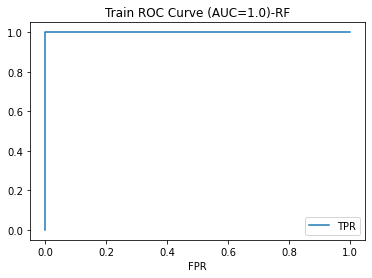

In [ ]:
# Plot roc train
plot_train = roc_df_train.plot(
    x="FPR",
    y="TPR",
    xlim=([-0.05, 1.05]),
    title=f"Train ROC Curve (AUC={auc_train})-RF",
)

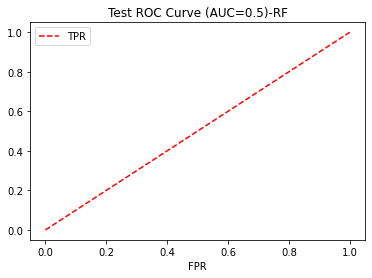

In [ ]:
plot_test = roc_df_test.plot(
    x="FPR",
    y="TPR",
    color="red",
    style="--",
    xlim=([-0.05, 1.05]),
    title=f"Test ROC Curve (AUC={auc_test})-RF",
)

In [ ]:
# List the features sorted in descending order by feature importance
importances = rf_model.feature_importances_
df_importances = pd.DataFrame(sorted(zip(rf_model.feature_importances_, X.columns), reverse= True))
df_importances

,0,1
0,0.030967,14_ROC
1,0.029641,21 Williams %R
2,0.029580,21_ROC
3,0.029245,14 period RSI
4,0.027780,5 period RSI
...,...,...
67,0.006411,21_pivot
68,0.006328,5_s1
69,0.006294,5_r1
70,0.006292,5_r2


In [ ]:
# Define the variable importance plot
def variable_importance(df):
    plot = df.hvplot.barh("1", stacked=True, height=1200)
    return plot

In [ ]:
# Plot the importance level 
variable_importance(df_importances)

:Bars   [1]   (0)

#### 2. Model 2......

In [ ]:
#Using logistic Regression
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(solver='lbfgs', random_state=42)
model.fit(X_train_scaled, y_train)

LogisticRegression(random_state=42)

In [ ]:
#Calculate accuracy score
y_pred_2 = model.predict(X_test_scaled)
print(accuracy_score(y_test, y_pred_2))



0.5512465373961218


In [ ]:
#Display confusion matrix
confusion_matrix(y_test, y_pred_2)

array([[ 23, 133],
       [ 29, 176]])

In [ ]:
#Print classification report
print(classification_report(y_test, y_pred_2))

              precision    recall  f1-score   support

         0.0       0.44      0.15      0.22       156
         1.0       0.57      0.86      0.68       205

    accuracy                           0.55       361
   macro avg       0.51      0.50      0.45       361
weighted avg       0.51      0.55      0.48       361



In [ ]:
#Using Gradient Boosting Classifier
from sklearn.ensemble import GradientBoostingClassifier

In [ ]:
#choosing learning rates
learning_rates = [0.05, 0.1, 0.25, 0.5, 0.75, 1]
for learning_rate in learning_rates:
    model_2 = GradientBoostingClassifier(
        n_estimators=10,
        learning_rate=learning_rate,
        max_features='log2',
        max_depth=2,
        random_state=42)
    model_2.fit(X_train_scaled, y_train.ravel())
    print('Learning Rate: ', learning_rate)

    #Score the model
    print("Accuracy score (training): {0:.3f}".format(
        model_2.score(
            X_train_scaled,
            y_train.ravel())))
    print("Accuracy score (validation): {0:.3f}".format(
        model_2.score(
            X_test_scaled,
            y_test.ravel())))
    print()

Learning Rate:  0.05
Accuracy score (training): 0.608
Accuracy score (validation): 0.507

Learning Rate:  0.1
Accuracy score (training): 0.615
Accuracy score (validation): 0.515

Learning Rate:  0.25
Accuracy score (training): 0.654
Accuracy score (validation): 0.468

Learning Rate:  0.5
Accuracy score (training): 0.701
Accuracy score (validation): 0.440

Learning Rate:  0.75
Accuracy score (training): 0.733
Accuracy score (validation): 0.435

Learning Rate:  1
Accuracy score (training): 0.752
Accuracy score (validation): 0.438



In [ ]:
#building the model using grading boosting classifier
model_2 = GradientBoostingClassifier(
    n_estimators=10,
    learning_rate=0.1,
    max_features='log2',
    max_depth=2,
    random_state=42,
    verbose=True)
#fitting the model
model_2.fit(X_train_scaled, y_train.ravel())

      Iter       Train Loss   Remaining Time 
         1           1.3389            0.01s
         2           1.3338            0.01s
         3           1.3294            0.01s
         4           1.3255            0.01s
         5           1.3203            0.01s
         6           1.3155            0.01s
         7           1.3124            0.00s
         8           1.3071            0.00s
         9           1.3046            0.00s
        10           1.2987            0.00s


GradientBoostingClassifier(max_depth=2, max_features='log2', n_estimators=10,
                           random_state=42, verbose=True)

In [ ]:
#Make predictions
predictions =model_2.predict(X_test_scaled)

#Generating accuracy score
accuracy_score(y_test, predictions)

0.5152354570637119

In [ ]:
#Evaluating the model using confusion matrix
cm = confusion_matrix(y_test, predictions)
cm_df = pd.DataFrame(
    cm, index=['Actual 0', 'Actual 1'], columns=['Predicted 0', 'Predicted 1']
)
display(cm_df)

,Predicted 0,Predicted 1
Actual 0,113,43
Actual 1,132,73


In [ ]:
#Generating classification report
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

         0.0       0.46      0.72      0.56       156
         1.0       0.63      0.36      0.45       205

    accuracy                           0.52       361
   macro avg       0.55      0.54      0.51       361
weighted avg       0.56      0.52      0.50       361



#### 3. Model 3......

#### 4. Model 4......

#### 5. Model 5 ......

### IV. ANALYSIS AND EVALUATION (TEAM WORK)

### V. DEPLOYING MODEL (TEAM WORK)

### VI. CONCLUSION (TEAM WORK)